In [1]:
#!pip3 install fastai

In [1]:
from fastai.vision import *

In [2]:
data = ImageList.from_folder('./images') \
                .split_by_rand_pct() \
                .label_from_re(r'images/(.*)_p') \
                .databunch()

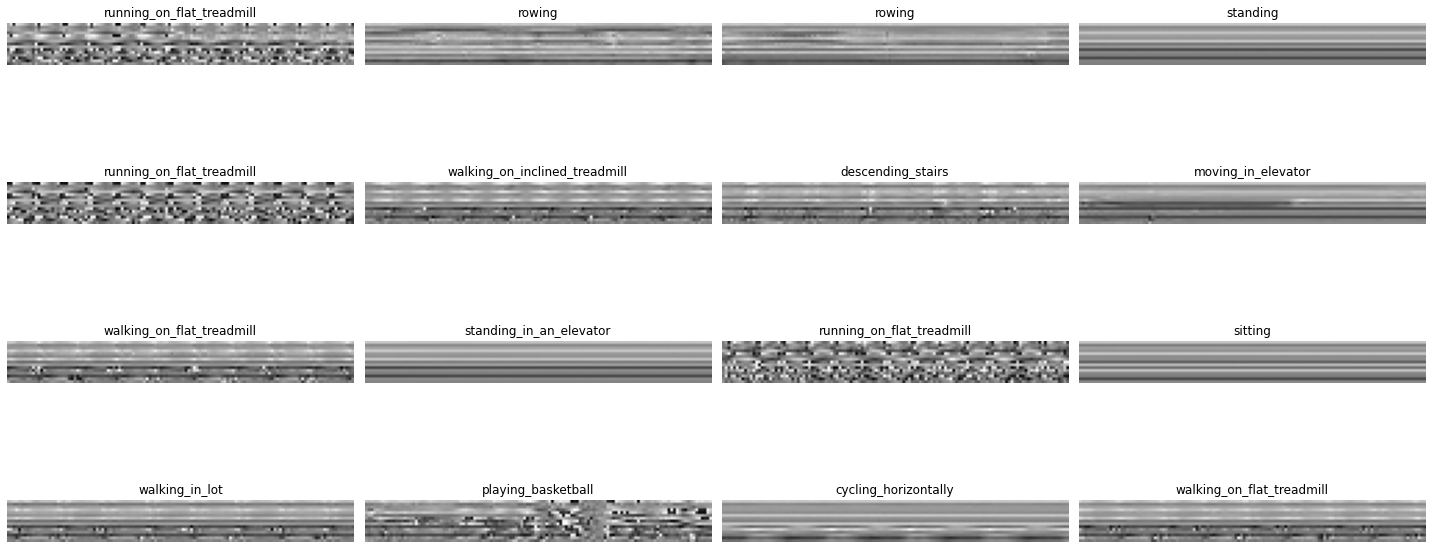

In [39]:
data.show_batch(4, figsize=(20,10))

In [4]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy)
learn.save('recnet-resnet34-stage0')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


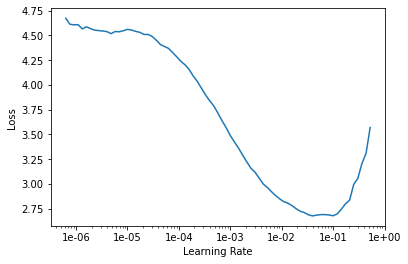

In [34]:
learn.load('recnet-resnet34-stage0')
learn.lr_find()
learn.recorder.plot()

In [35]:
learn.fit_one_cycle(15, slice(1e-4,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.799067,0.342147,0.885965,00:04
1,0.407525,0.262173,0.925439,00:04
2,0.362973,0.290630,0.915570,00:04
3,0.372147,0.298919,0.938596,00:04
4,0.426512,0.254494,0.916118,00:04
5,0.241211,0.111238,0.970395,00:04
6,0.189393,0.145263,0.957785,00:04
7,0.132538,0.106256,0.970395,00:04
8,0.148783,0.223906,0.941338,00:04
9,0.108985,0.107308,0.969298,00:04


Only training the last fully conencted layer leads to a 98.7% accuracy. Only in the last 4 epochs did the training loss drop underd the validation loss, so likely no overfitting.

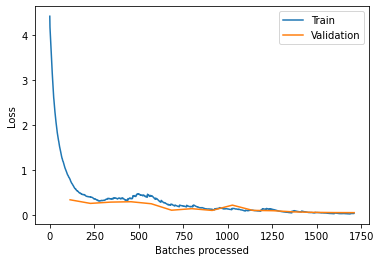

In [36]:
learn.recorder.plot_losses()

I like this loss plot. Often, if we pick a more aggressive learning rate, we might see some spikes in validation loss. However, intuition tells us that we expect this with the one cycle policy, especially as we approach the more aggressive learning rate half way through the epochs. You can see in the table above that at the 8th epoch we did see a small spike in valid loss, but as we decreased learning rate and approached annihilation, our training loss dipped under validation loss, and we achieved a nice increase in our accuracy

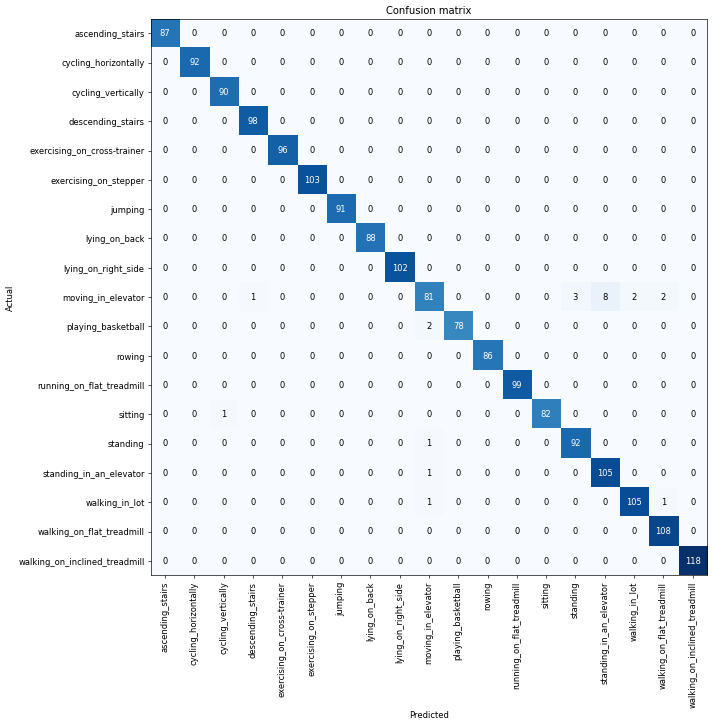

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

It looks like of the few errors that are made, when the actual class is `moving_in_elevator`, our net predicts it as `standing_in_elevator`. Totally understandable.

In [40]:
learn.save('recnet-resnet34-stage1')

Let's see if there's any worth in unfreezing the entire model and doing some training.

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


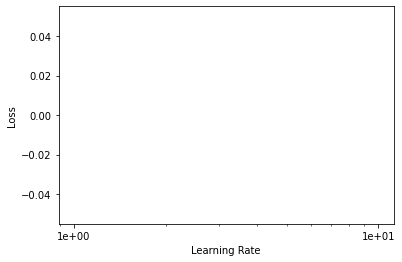

In [41]:
learn.load('recnet-resnet34-stage1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

I guess it's not really worth it. Looking at `doc(lr_find)` we see this description
> Explore lr from start_lr to end_lr over num_it iterations in learn. If stop_div, stops when loss diverges.

Clearly, the system diverged immediatlely, which either means training is pointless, or I should start from an even smaller learning rate. I decided to forgo that, and end the experiment here.

I'm happy with the outcome of this little experiment. My objectives were

1. Learn fastAI's datablock library
2. Understand how effective transfer learning is

The datablock library was extremely simple to use. In fact, I spent the longest amount of time in this experiment creating the images. After that, consuming the images, and doing the training and validation was dirt simple.

The 98.7% accuracy I achieved here beats the max accuracy of 95.5% for the accelerometer-only classification detailed in the paper. Note that the paper wasn't trying to achieve the highest accuracy through any fine tuning, only testing two different open source proejcts. Regardless, this demonstrates how effective transfer learning can be. On top of that, these images are nothing like the images resnet34 was trained on. They are rectangular, grayscale, and have nothing in common with actual objects, yet it did a fantastic job of classification.